In [5]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard.writer import SummaryWriter
import random

Загрузка данных

In [6]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

df = pd.read_csv('./content/tripadvisor_hotel_reviews.csv')

df['Review'] = df['Review'].apply(lambda x: x.lower().split())

label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])

print(df.head())

                                              Review  Rating
0  [nice, hotel, expensive, parking, got, good, d...       3
1  [ok, nothing, special, charge, diamond, member...       1
2  [nice, rooms, not, 4*, experience, hotel, mona...       2
3  [unique,, great, stay,, wonderful, time, hotel...       4
4  [great, stay, great, stay,, went, seahawk, gam...       4


In [7]:
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Rating'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['Rating'], random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 12294, Validation size: 4098, Test size: 4099


Создание Dataset и DataLoader

In [8]:
class ReviewsDataset(Dataset):
    def __init__(self, df, vocab=None):
        self.reviews = df['Review'].tolist()
        self.ratings = df['Rating'].tolist()
        self.vocab = vocab or self.build_vocab(self.reviews)

    def build_vocab(self, reviews):
        unique_words = set(word for review in reviews for word in review)
        word2idx = {word: idx+1 for idx, word in enumerate(unique_words)}
        word2idx["<PAD>"] = 0
        return word2idx

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        rating = self.ratings[idx]
        encoded_review = [self.vocab.get(word, 0) for word in review]
        return torch.tensor(encoded_review, dtype=torch.long), torch.tensor(rating, dtype=torch.long)

train_dataset = ReviewsDataset(train_df)
val_dataset = ReviewsDataset(val_df, vocab=train_dataset.vocab)
test_dataset = ReviewsDataset(test_df, vocab=train_dataset.vocab)

def collate_fn(batch):
    reviews, ratings = zip(*batch)
    reviews_padded = pad_sequence(reviews, batch_first=True, padding_value=0)
    return reviews_padded, torch.tensor(ratings, dtype=torch.long)

batch_size = 64  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Реализация и обучение сверточной сети

In [11]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_size, 128, kernel_size=5)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=5)
        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.max(dim=2)[0]
        x = self.fc1(x)
        return x

vocab_size = len(train_dataset.vocab)
embed_size = 100
num_classes = len(label_encoder.classes_)

text_cnn_model = TextCNN(vocab_size, embed_size, num_classes)

def train(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for reviews, ratings in train_loader:
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss/len(train_loader)}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for reviews, ratings in val_loader:
                outputs = model(reviews)
                loss = criterion(outputs, ratings)
                val_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}')

train(text_cnn_model, train_loader, val_loader)


Epoch 1/10, Training Loss: 1.2898850842461067
Epoch 1/10, Validation Loss: 1.1950196926410381
Epoch 2/10, Training Loss: 1.077924562241747
Epoch 2/10, Validation Loss: 1.08942208473499
Epoch 3/10, Training Loss: 0.86189955843545
Epoch 3/10, Validation Loss: 1.0827121156912582
Epoch 4/10, Training Loss: 0.6199055025305773
Epoch 4/10, Validation Loss: 1.1670375145398653
Epoch 5/10, Training Loss: 0.359051164258947
Epoch 5/10, Validation Loss: 1.2661362061133752
Epoch 6/10, Training Loss: 0.154506262681336
Epoch 6/10, Validation Loss: 1.4065869679817786
Epoch 7/10, Training Loss: 0.050540596719618906
Epoch 7/10, Validation Loss: 1.5418601806347187
Epoch 8/10, Training Loss: 0.017646517826562718
Epoch 8/10, Validation Loss: 1.6599964857101441
Epoch 9/10, Training Loss: 0.009581092749891195
Epoch 9/10, Validation Loss: 1.7429276172931378
Epoch 10/10, Training Loss: 0.00666111285696916
Epoch 10/10, Validation Loss: 1.820356402030358


Реализация и обучение рекуррентной сети

In [12]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_classes):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

hidden_size = 128
num_layers = 1

text_lstm_model = TextLSTM(vocab_size, embed_size, hidden_size, num_layers, num_classes)

train(text_lstm_model, train_loader, val_loader)

Epoch 1/10, Training Loss: 1.374961325541679
Epoch 1/10, Validation Loss: 1.3658284425735474
Epoch 2/10, Training Loss: 1.359618725554313
Epoch 2/10, Validation Loss: 1.36868993135599
Epoch 3/10, Training Loss: 1.3544477570242215
Epoch 3/10, Validation Loss: 1.3640710463890662
Epoch 4/10, Training Loss: 1.3545027180656868
Epoch 4/10, Validation Loss: 1.364708819756141
Epoch 5/10, Training Loss: 1.352204235724217
Epoch 5/10, Validation Loss: 1.366088186777555
Epoch 6/10, Training Loss: 1.348256594158825
Epoch 6/10, Validation Loss: 1.3627037855295034
Epoch 7/10, Training Loss: 1.3473729766094622
Epoch 7/10, Validation Loss: 1.369931176992563
Epoch 8/10, Training Loss: 1.3455671226422403
Epoch 8/10, Validation Loss: 1.368179805462177
Epoch 9/10, Training Loss: 1.344526857909761
Epoch 9/10, Validation Loss: 1.3683237534302932
Epoch 10/10, Training Loss: 1.3459024997572824
Epoch 10/10, Validation Loss: 1.3668203592300414


In [13]:
def train_and_evaluate(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        for reviews, ratings in train_loader:
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == ratings).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for reviews, ratings in val_loader:
                outputs = model(reviews)
                loss = criterion(outputs, ratings)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == ratings).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

Обучение моделей

In [14]:
cnn_train_losses, cnn_val_losses, cnn_train_acc, cnn_val_acc = train_and_evaluate(text_cnn_model, train_loader, val_loader, epochs=10)

lstm_train_losses, lstm_val_losses, lstm_train_acc, lstm_val_acc = train_and_evaluate(text_lstm_model, train_loader, val_loader, epochs=10)

Epoch 1/10, Train Loss: 0.0136, Train Accuracy: 0.9994, Val Loss: 2.2342, Val Accuracy: 0.5034
Epoch 2/10, Train Loss: 0.0191, Train Accuracy: 0.9960, Val Loss: 2.2907, Val Accuracy: 0.5056
Epoch 3/10, Train Loss: 0.0027, Train Accuracy: 1.0000, Val Loss: 2.3394, Val Accuracy: 0.5310
Epoch 4/10, Train Loss: 0.0007, Train Accuracy: 1.0000, Val Loss: 2.3696, Val Accuracy: 0.5305
Epoch 5/10, Train Loss: 0.0005, Train Accuracy: 1.0000, Val Loss: 2.3969, Val Accuracy: 0.5278
Epoch 6/10, Train Loss: 0.0004, Train Accuracy: 1.0000, Val Loss: 2.4267, Val Accuracy: 0.5307
Epoch 7/10, Train Loss: 0.0003, Train Accuracy: 1.0000, Val Loss: 2.4556, Val Accuracy: 0.5300
Epoch 8/10, Train Loss: 0.0002, Train Accuracy: 1.0000, Val Loss: 2.4780, Val Accuracy: 0.5300
Epoch 9/10, Train Loss: 0.0011, Train Accuracy: 0.9997, Val Loss: 2.5673, Val Accuracy: 0.5337
Epoch 10/10, Train Loss: 0.1492, Train Accuracy: 0.9476, Val Loss: 2.8761, Val Accuracy: 0.4968
Epoch 1/10, Train Loss: 1.3426, Train Accuracy: 0

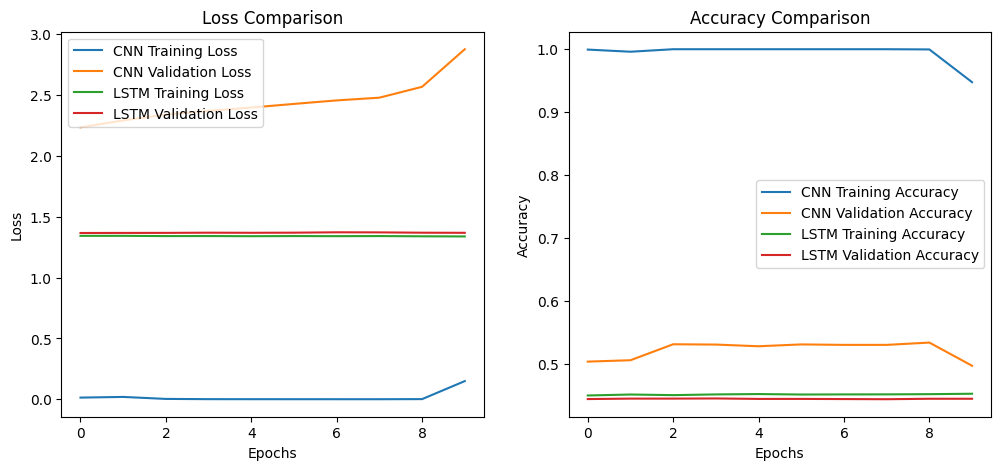

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='CNN Training Loss')
plt.plot(cnn_val_losses, label='CNN Validation Loss')
plt.plot(lstm_train_losses, label='LSTM Training Loss')
plt.plot(lstm_val_losses, label='LSTM Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_train_acc, label='CNN Training Accuracy')
plt.plot(cnn_val_acc, label='CNN Validation Accuracy')
plt.plot(lstm_train_acc, label='LSTM Training Accuracy')
plt.plot(lstm_val_acc, label='LSTM Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [18]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for reviews, ratings in test_loader:
            outputs = model(reviews)


            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ratings.cpu().numpy())

    return all_labels, all_preds

cnn_labels, cnn_preds = evaluate_model(text_cnn_model, test_loader)
lstm_labels, lstm_preds = evaluate_model(text_lstm_model, test_loader)

target_names = [str(cls) for cls in label_encoder.classes_]  

print("CNN:")
print(classification_report(cnn_labels, cnn_preds, target_names=target_names))

print("LSTM:")
print(classification_report(lstm_labels, lstm_preds, target_names=target_names))

CNN:
              precision    recall  f1-score   support

           1       0.57      0.33      0.42       284
           2       0.33      0.36      0.34       359
           3       0.27      0.20      0.23       437
           4       0.40      0.59      0.47      1208
           5       0.71      0.56      0.62      1811

    accuracy                           0.50      4099
   macro avg       0.45      0.41      0.42      4099
weighted avg       0.53      0.50      0.50      4099

LSTM:
              precision    recall  f1-score   support

           1       0.33      0.00      0.01       284
           2       0.18      0.01      0.01       359
           3       0.43      0.01      0.01       437
           4       0.39      0.01      0.02      1208
           5       0.44      0.99      0.61      1811

    accuracy                           0.44      4099
   macro avg       0.36      0.20      0.13      4099
weighted avg       0.40      0.44      0.28      4099



- CNN: Модель CNN показала точность 50%. Хотя это не очень высокий результат, он лучше, чем случайное угадывание для многоклассовой задачи с пятью классами
- LSTM: Модель LSTM показала еще более низкую точность — 44%, что свидетельствует о более низкой эффективности по сравнению с CNN